# Preprocessing

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from xgboost import XGBClassifier
import pickle

from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from sklearn.metrics import classification_report

import nltk
from nltk.corpus import stopwords
from sklearn.preprocessing import LabelEncoder
import gensim.downloader as api

In [35]:
with open('./preprocessed/indexes.pkl', 'rb') as f:
    data_idxs = pickle.load(f)

In [36]:
data_idxs.keys()

dict_keys(['train', 'validation', 'test'])

In [3]:
fasttext_model = api.load("fasttext-wiki-news-subwords-300") # Download pretrained model
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/nikolay/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/nikolay/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [12]:
CLASS = 'Discussion'
DATA_SAVE_PATH = f"./data/cleaned_data.csv"
CONTEXT = False
HISTORY = False
USE_TEXT = 'message'

REMOVE_STOPWORDS = True
REMOVE_NUM = False

other_classes_to_predict = ['Discussion', 'Dialogic Spell', 'Uptake', 'Question', 'Pivot']
other_classes_to_predict.remove(CLASS)
remove_also = ['topic']
remove_also += other_classes_to_predict

In [13]:
def preprocess_text(text):
    # Tokenization, lowercasing, removing stopwords, etc.
    tokens = [word.lower() for word in nltk.word_tokenize(text)]
    
    if REMOVE_NUM:
        tokens = [word for word in tokens if word.isalpha()]

    if REMOVE_STOPWORDS:
        tokens = [word for word in tokens if word not in stop_words]

    return ' '.join(tokens)

data = pd.read_csv(DATA_SAVE_PATH)
data[USE_TEXT] = data[USE_TEXT].apply(preprocess_text)
data.drop(columns=remove_also, inplace=True)

if not CONTEXT:
    data = data[[USE_TEXT, CLASS]]


In [14]:
# Convert text data into numerical vectors using FastText word embeddings
def get_embedding(text):
    # Initialize an empty vector
    vector = np.zeros(300)
    # Iterate over each word in the text
    for word in text.split():
        # If the word is in the FastText vocabulary, add its embedding to the vector
        if word in fasttext_model:
            vector += fasttext_model[word]
        else:
            print(f"Word '{word}' not in vocabulary")
    # Return the vector
    return vector

mess_embeddings = pd.DataFrame(data[USE_TEXT].apply(get_embedding).tolist())

data = pd.concat([data, mess_embeddings], axis=1)

Word '''' not in vocabulary
Word '''' not in vocabulary
Word 'n't' not in vocabulary
Word 'n't' not in vocabulary
Word 'ashely' not in vocabulary
Word '``' not in vocabulary
Word '''' not in vocabulary
Word 'orgininally' not in vocabulary
Word 'thoughts/suggestions' not in vocabulary
Word 'uwgyeu' not in vocabulary
Word '''' not in vocabulary
Word '``' not in vocabulary
Word '''' not in vocabulary
Word '''' not in vocabulary
Word 'kyra' not in vocabulary
Word 'emilie' not in vocabulary
Word 'n't' not in vocabulary
Word '``' not in vocabulary
Word '''' not in vocabulary
Word 'n't' not in vocabulary
Word 'n't' not in vocabulary
Word 'n't' not in vocabulary
Word 'lis6303' not in vocabulary
Word 'lis6303' not in vocabulary
Word 'emilie' not in vocabulary
Word 'kyra' not in vocabulary
Word 'n't' not in vocabulary
Word 'kyra' not in vocabulary
Word ''my' not in vocabulary
Word 'n't' not in vocabulary
Word 'n't' not in vocabulary
Word 'darla' not in vocabulary
Word 'experien' not in vocabular

In [15]:
y = data[CLASS].fillna('None')
if CONTEXT:
    data['course'] = LabelEncoder().fit_transform(data['course'])
    data['book_id'] = data['book_id'].astype(int)
    data['bookclub'] = data['bookclub'].astype(int)
    data['chat_crew'] = data['chat_crew'].astype(bool)
    data['pseudonym'] = LabelEncoder().fit_transform(data['pseudonym'])

    data['time'] = pd.to_datetime(data['time'], errors='coerce')

    data['year'] = data['time'].dt.year
    data['month'] = data['time'].dt.month
    data['day'] = data['time'].dt.day
    data['hour'] = data['time'].dt.hour
    data['minute'] = data['time'].dt.minute
    data['second'] = data['time'].dt.second

    data['page'] = data['page'].fillna(0).astype(int)
    data['response_number'] = data['response_number'].fillna(0).astype(float)

    data.drop(columns=['time', 'message', CLASS], inplace=True)
else:
    data.drop(columns=['message', CLASS], inplace=True)

In [16]:
data

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,-0.031234,0.049419,0.138971,0.069366,-0.019319,-0.029924,0.005459,0.176240,-0.189661,-0.067056,...,-0.013779,0.022800,-0.092358,-0.017482,0.013601,0.080624,0.066292,0.046231,-0.012138,0.030565
1,-0.012513,0.045208,-0.010798,0.012756,-0.071588,0.012889,0.042728,-0.106160,-0.058726,-0.003324,...,-0.003363,0.052115,0.065980,0.001060,0.065079,0.045248,0.018545,-0.095000,-0.009200,-0.000744
2,0.023686,0.000210,0.224866,0.093990,-0.106215,-0.076056,-0.113144,-0.300181,-0.165749,0.041533,...,-0.112988,0.247253,-0.155032,0.019716,-0.044911,-0.018376,0.160402,0.128757,-0.210666,0.010261
3,-0.007433,-0.016271,-0.046155,0.070818,-0.081339,-0.083072,0.073027,-0.420168,-0.218404,0.046978,...,-0.074846,-0.002551,-0.055417,0.033639,-0.033324,-0.028483,0.033206,-0.028945,0.146593,-0.080365
4,-0.004315,-0.103644,0.257470,0.151194,-0.196984,-0.098948,-0.051496,-0.309674,-0.143451,0.139537,...,-0.016727,-0.042201,-0.132990,0.015535,0.029289,0.083799,0.236626,-0.185515,-0.119007,-0.001828
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
900,-0.017933,-0.249814,-0.040124,0.049823,-0.003092,-0.114786,-0.080800,-0.621400,-0.111078,0.114733,...,-0.038870,-0.110659,-0.046344,-0.006085,0.001381,0.090643,0.068942,0.043535,0.021323,-0.106796
901,0.060934,0.084670,-0.040256,0.023700,-0.041099,-0.230358,0.016903,-0.766339,-0.172518,-0.002966,...,0.061649,0.039128,-0.096955,0.002076,0.088766,-0.001816,-0.051192,0.125032,0.073620,-0.170250
902,0.163171,0.091426,-0.011786,0.030308,-0.212713,-0.382394,-0.020469,-1.556645,-0.067207,-0.126410,...,-0.071359,0.087558,-0.009193,-0.155353,0.167293,-0.077260,0.198589,-0.260083,-0.024904,-0.386629
903,0.076193,0.023702,-0.051157,0.098408,0.002623,-0.066553,0.018085,-0.438689,-0.188412,-0.006724,...,0.019197,-0.015293,0.113176,-0.010439,0.002657,-0.049355,-0.010216,-0.081569,0.051319,0.000576


In [17]:
# Convert labels to numerical labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

In [37]:
data_idxs['train'].extend(data_idxs['validation'])

In [38]:
X_train = data.iloc[data_idxs['train']]
y_train = y[data_idxs['train']]

X_test = data.iloc[data_idxs['test']]
y_test = y[data_idxs['test']]

In [39]:
# Train an XGBoost classifier
xgb_classifier = XGBClassifier(objective='multi:softmax', num_class=len(label_encoder.classes_))
xgb_classifier.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None, num_class=7,
              num_parallel_tree=None, ...)

In [40]:
# Predict on the test set
y_pred = xgb_classifier.predict(X_test)

# Evaluate the model
print('Accuracy:', accuracy_score(y_test, y_pred))
print('Precision:', precision_score(y_test, y_pred, average='weighted', zero_division=0))
print('Recall:', recall_score(y_test, y_pred, average='weighted', zero_division=0))
print('F1:', f1_score(y_test, y_pred, average='weighted', zero_division=0))

print(classification_report(y_test, y_pred, target_names=label_encoder.classes_, zero_division=0))

Accuracy: 0.6187845303867403
Precision: 0.5798604623197056
Recall: 0.6187845303867403
F1: 0.5945955517778723
                   precision    recall  f1-score   support

     Deliberation       0.53      0.69      0.60        45
Imaginative Entry       0.00      0.00      0.00         6
            Other       0.00      0.00      0.00         2
        Procedure       0.29      0.15      0.20        13
          Seminar       0.75      0.79      0.77        89
           Social       0.43      0.38      0.40        16
               UX       0.38      0.30      0.33        10

         accuracy                           0.62       181
        macro avg       0.34      0.33      0.33       181
     weighted avg       0.58      0.62      0.59       181



In [43]:
np.save("./pred_results/xgboost", label_encoder.inverse_transform(y_pred))

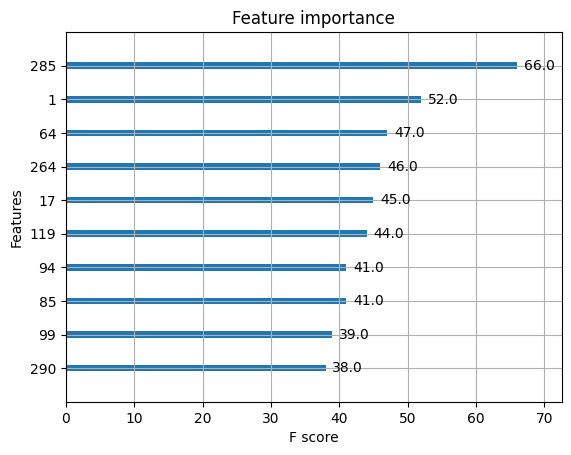

In [44]:
import xgboost as xgb
import matplotlib.pyplot as plt

# Assuming xgb_classifier is your trained model
xgb.plot_importance(xgb_classifier, max_num_features=10)

plt.savefig("overfit.pdf")

In [46]:
bert = np.load("./pred_results/BERT.npy", allow_pickle=True)
xgboost_pred = np.load("./pred_results/xgboost.npy", allow_pickle=True)

ValueError: Object arrays cannot be loaded when allow_pickle=False

In [ ]:
np.sum(bert == xgboost_pred) / len(bert)